In [34]:
import torch
import torch.nn as nn

class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, dilation=1):
        super(BasicConv, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False, groups=groups, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv1(x)
    
class DwSepConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1, bias=False):
        super(DwSepConv, self).__init__()
        padding = dilation if dilation > kernel_size // 2 else kernel_size // 2
        self.depthwise = BasicConv(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, dilation=dilation)
        self.pointwise = BasicConv(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
    
# EnrtyFlow
class EntryFlow(nn.Module):
    def __init__(self, enf_s):
        super(EntryFlow, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.conv2_residual = nn.Sequential(
            DwSepConv(64, 128, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            DwSepConv(128, 128, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            DwSepConv(128, 128, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.conv2_shortcut = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride=2, padding=0),
            nn.BatchNorm2d(128)
        )

        self.conv3_residual = nn.Sequential(
            nn.ReLU(inplace=True),
            DwSepConv(128, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            DwSepConv(256, 256),
            nn.BatchNorm2d(256),
            DwSepConv(256, 256, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)            
        )

        self.conv3_shortcut = nn.Sequential(
            nn.Conv2d(128, 256, 1, stride=2, padding=0),
            nn.BatchNorm2d(256)
        )

        self.conv4_residual = nn.Sequential(
            nn.ReLU(inplace=True),
            DwSepConv(256, 728),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True),
            DwSepConv(728, 728),
            nn.BatchNorm2d(728),
            DwSepConv(728, 728, stride=enf_s),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True)            
        )

        self.conv4_shortcut = nn.Sequential(
            nn.Conv2d(256, 728, 1, stride=enf_s, padding=0),
            nn.BatchNorm2d(728)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_residual(x) + self.conv2_shortcut(x)
        low_level_features = x
        x = self.conv3_residual(x) + self.conv3_shortcut(x)
        x = self.conv4_residual(x) + self.conv4_shortcut(x)
        return x, low_level_features
    
# MiddleFlow
class MiddleFlow(nn.Module):
    def __init__(self, mf_d):
        super(MiddleFlow, self).__init__()
        self.conv_residual = nn.Sequential(
            nn.ReLU(inplace=True),
            DwSepConv(728, 728, dilation=mf_d),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True),
            DwSepConv(728, 728, dilation=mf_d),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True),
            DwSepConv(728, 728, dilation=mf_d),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True)
        )

        self.conv_shortcut = nn.Sequential()

    def forward(self, x):
        x = self.conv_shortcut(x) + self.conv_residual(x)
        return x
    
# ExitFlow
class ExitFlow(nn.Module):
    def __init__(self, exf_d):
        super(ExitFlow, self).__init__()
        self.conv1_residual = nn.Sequential(
            nn.ReLU(inplace=True),
            DwSepConv(728, 1024, dilation=exf_d[0]),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            DwSepConv(1024, 1024, dilation=exf_d[0]),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            DwSepConv(1024, 1024, dilation=exf_d[0]),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        self.conv1_shortcut = nn.Sequential(
            nn.Conv2d(728, 1024, 1, stride=1, padding=0),
            nn.BatchNorm2d(1024)
        )

        self.conv2 = nn.Sequential(
            DwSepConv(1024, 1536, kernel_size=3, stride=1, dilation=exf_d[1]),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace=True),
            DwSepConv(1536, 1536, kernel_size=3, stride=1, dilation=exf_d[1]),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace=True),            
            DwSepConv(1536, 2048, kernel_size=3, stride=1, dilation=exf_d[1]),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv1_residual(x) + self.conv1_shortcut(x)
        x = self.conv2(x)
        return x
    
# Xception
class Xception(nn.Module):
    def __init__(self, output_stride):
        super(Xception, self).__init__()
        if output_stride == 16:
            enf_s, mdf_d, exf_d = 2, 1, (1, 2)
        elif output_stride == 8:
            enf_s, mdf_d, exf_d = 1, 2, (2, 4)
        else:
            raise ValueError("output_stride == 8 or 16!!")
        
        self.entry = EntryFlow(enf_s)
        self.middle = self._make_middle_flow(mdf_d)
        self.exit = ExitFlow(exf_d)
        
        self._initialize_weights()

    def forward(self, x):
        x, low_level_features = self.entry(x)
        x = self.middle(x)
        x = self.exit(x)
        return x, low_level_features

    def _make_middle_flow(self, dilation):
        middle = nn.Sequential()
        for i in range(16):
            middle.add_module('middle_block_{}'.format(i), MiddleFlow(dilation))
        return middle

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# # check model
# if __name__ == "__main__":
#     model = Xception(output_stride=16)
#     input_tensor = torch.randn([3, 3, 512, 512])
#     output, low_level_features = model(input_tensor)
#     print(f"Final output shape: {output.shape}")
#     print(f"Low-level features shape: {low_level_features.shape}")


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ASPPConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(ASPPConv, self).__init__()
        padding = 0 if kernel_size == 1 else dilation  # kernel_size가 1일 때 padding을 0으로 설정
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class ASPPPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
            size = x.shape[2:]  # 입력의 공간 크기 저장
            x = self.pool(x)
            x = self.conv(x)
            return F.interpolate(x, size=size, mode='bilinear', align_corners=True)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, output_stride):
        super(ASPP, self).__init__()
        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise ValueError("output_stride == 8 or 16!!")

        self.conv1 = ASPPConv(in_channels, out_channels, kernel_size=1, dilation=dilations[0])
        self.conv2 = ASPPConv(in_channels, out_channels, kernel_size=3, dilation=dilations[1])
        self.conv3 = ASPPConv(in_channels, out_channels, kernel_size=3, dilation=dilations[2])
        self.conv4 = ASPPConv(in_channels, out_channels, kernel_size=3, dilation=dilations[3])
        self.pool = ASPPPooling(in_channels, out_channels)

        self.project = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.pool(x)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)  # 채널 방향으로 연결
        return self.project(x)

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, low_level_channels, num_classes):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(low_level_channels, 48, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU(inplace=True)

        self.output = nn.Sequential(
            nn.Conv2d(48 + 128, 256, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(256, num_classes, 1, stride=1),
        )

    def forward(self, x, low_level_features):
        low_level_features = self.conv1(low_level_features)
        low_level_features = self.relu(self.bn1(low_level_features))
        H, W = low_level_features.size(2), low_level_features.size(3)

        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        x = self.output(torch.cat((low_level_features, x), dim=1))
        return x

    
class DeepLabV3P(nn.Module):
    def __init__(self, num_classes, output_stride):
        super(DeepLabV3P, self).__init__()

        # Xception
        self.backbone = Xception(output_stride=output_stride)
        
        ASPP
        self.aspp = ASPP(in_channels=2048, out_channels=128, output_stride=output_stride)

        # Decoder
        self.decoder = Decoder(num_classes=num_classes, low_level_channels=128)


    def forward(self, x):
        H, W = x.size(2), x.size(3)
        x, low_level_features = self.backbone(x)
        x = self.aspp(x)
        x = self.decoder(x, low_level_features)
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        return x

if __name__ == "__main__":
    model = DeepLabV3P(num_classes=21, output_stride=16)
    input_tensor = torch.randn(3, 3, 512, 512)
    output = model(input_tensor)
    # 출력 형태 확인
    print("Output shape:", output.shape)

Output shape: torch.Size([3, 21, 512, 512])


In [37]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset  # Dataset 클래스 임포트

class CIHPDataset(Dataset):
    def __init__(self, image_dir='/kaggle/input/ccccc1/instance-level_human_parsing/instance-level_human_parsing/images', 
                 mask_dir='/kaggle/input/ccccc1/instance-level_human_parsing/instance-level_human_parsing/masks', 
                 transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform

        self.image_list = sorted(os.listdir(self.image_dir))
        self.mask_list = sorted(os.listdir(self.mask_dir))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # 이미지 및 마스크 경로
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        # 이미지 및 마스크 로드
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        # Transform 적용
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        else:
            mask = np.array(mask, dtype=np.int64)

        return image, mask


In [38]:
# !pip install --upgrade gdown  # Update gdown to the latest version
# import gdown
# import os

# # # 데이터셋 다운로드 using gdown
# # file_id = '1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz'
# # output = 'instance-level_human_parsing.zip'

# # # Remove the 'force' argument as it is not supported by gdown.download() anymore
# # gdown.download(id=file_id, output=output, quiet=False)

# # Check file size to detect potential download issues
# # file_size = os.path.getsize(output)
# # print(f"Downloaded file size: {file_size} bytes")

# # 압축 해제 using 7z
# # 압축 파일 경로
# zip_file_path = '/kaggle/working/instance-level_human_parsing.zip'

# # 압축 해제 using 7z
# !apt-get install p7zip-full -y  # 7z 설치
# !7z x "{zip_file_path}" -o"/kaggle/working/"  # 압축 해제 경로를 /kaggle/working/으로 지정
# print("File extracted successfully to /kaggle/working/ using 7z.")


In [39]:
import os

# instance-level_human_parsing 디렉토리 내용 확인
data_dir = '/kaggle/input/ccccc1/instance-level_human_parsing/instance-level_human_parsing'

print("\nContents of 'instance-level_human_parsing':")
print(os.listdir(data_dir))

# 실제 데이터 경로 설정
image_dir = os.path.join(data_dir, 'Training/Images')
mask_dir = os.path.join(data_dir, 'Training/Category_ids')
colormap_path = os.path.join(data_dir, 'human_colormap.mat')

# 디렉토리 존재 여부 확인
print(f"\nImage Directory Exists: {os.path.exists(image_dir)}")
print(f"Mask Directory Exists: {os.path.exists(mask_dir)}")

# 디렉토리 내용 확인
print("\nContents of image_dir:")
print(os.listdir(image_dir)[:5])  # 첫 5개 파일만 출력

print("\nContents of mask_dir:")
print(os.listdir(mask_dir)[:5])  # 첫 5개 파일만 출력



Contents of 'instance-level_human_parsing':
['Validation', 'Training', 'README.md', 'Testing', 'human_colormap.mat']

Image Directory Exists: True
Mask Directory Exists: True

Contents of image_dir:
['0031266.jpg', '0019921.jpg', '0015674.jpg', '0022723.jpg', '0031455.jpg']

Contents of mask_dir:
['0020711.png', '0000693.png', '0031353.png', '0007332.png', '0033057.png']


In [40]:
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split


# 이미지 변환
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 기준값 사용
                         std=[0.229, 0.224, 0.225])
])

# 마스크 변환
def mask_transform(mask):
    mask = mask.resize((512, 512), resample=Image.NEAREST)
    mask = np.array(mask, dtype=np.int64)
    return torch.from_numpy(mask)

# 전체 데이터셋 로드
dataset = CIHPDataset(image_dir, mask_dir, transform=image_transform, target_transform=mask_transform)

# 데이터셋 분할 (훈련:검증 = 8:2)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터로더 생성
batch_size = 4  # 배치 크기를 조정하여 메모리 사용량을 관리합니다
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [41]:
num_classes = 20  # CIHP 데이터셋의 클래스 수 (배경 포함)
model = DeepLabV3P(num_classes=num_classes, output_stride=16).to(device)
print(model)

DeepLabV3P(
  (backbone): Xception(
    (entry): EntryFlow(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (conv2_residual): Sequential(
        (0): DwSepConv(
          (depthwise): BasicConv(
            (conv1): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (pointwise): BasicConv(
            (conv1): Sequential(
         

In [42]:
from torch.cuda.amp import GradScaler, autocast
# Loss function과 optimizer 설정
use_amp = True
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler() if use_amp else None

/tmp/ipykernel_31/4181638049.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


In [43]:
from tqdm import tqdm
# 학습 루프
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for images, masks in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        if use_amp:
            with autocast():
                outputs = model(images)
                outputs = F.interpolate(outputs, size=(512, 512), 
                                     mode='bilinear', align_corners=False)
                loss = criterion(outputs, masks)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            outputs = F.interpolate(outputs, size=(512, 512), 
                                  mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())
        
        # MPS 메모리 정리
        if device.type == 'mps':
            torch.mps.empty_cache()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            outputs = F.interpolate(outputs, size=(512, 512), 
                                  mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            if device.type == 'mps':
                torch.mps.empty_cache()
    
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")
    
    # 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, 'best_model.pth')


Epoch 1/10:   0%|          | 0/5656 [00:00<?, ?batch/s]/tmp/ipykernel_31/635364168.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 5656/5656 [44:02<00:00,  2.14batch/s, loss=1.09] 

Epoch [1/10], Loss: 1.1524


Validation Loss: 1.0421


Epoch 2/10: 100%|██████████| 5656/5656 [44:04<00:00,  2.14batch/s, loss=1.16] 

Epoch [2/10], Loss: 1.0190


Validation Loss: 0.9925


Epoch 3/10: 100%|██████████| 5656/5656 [44:04<00:00,  2.14batch/s, loss=0.966]

Epoch [3/10], Loss: 0.9697


Validation Loss: 1.0073


Epoch 4/10: 100%|██████████| 5656/5656 [44:04<00:00,  2.14batch/s, loss=0.876]

Epoch [4/10], Loss: 0.9300


Validation Loss: 0.9171


Epoch 5/10: 100%|██████████| 5656/5656 [44:03<00:00,  2.14batch/s, loss=0.873]

Epoch [5/10], Loss: 0.8977


Validation Loss: 0.8817


Epoch 6/10: 100%|██████████| 5656/5656 [44:03<00:00,  2.14batch/s, loss=0.73] 

Epoch [6/10], Loss: 0.8659


Validation Loss: 0.9414


Epoch 7/10: 100%|██████████| 5656/5656 [44:03<00:00,  2.14batch/s, loss=0.666]

Epoch [7/10], Loss: 0.8366


Validation Loss: 0.8660


Epoch 8/10: 100%|██████████| 5656/5656 [44:03<00:00,  2.14batch/s, loss=1.02] 

Epoch [8/10], Loss: 0.8225


Validation Loss: 0.8535


Epoch 9/10: 100%|██████████| 5656/5656 [44:03<00:00,  2.14batch/s, loss=0.633]

Epoch [9/10], Loss: 0.7957


Validation Loss: 0.7967


Epoch 10/10: 100%|██████████| 5656/5656 [44:03<00:00,  2.14batch/s, loss=0.667]

Epoch [10/10], Loss: 0.7763


Validation Loss: 0.8118


In [44]:
import scipy.io

# 결과 시각화
colormap = scipy.io.loadmat(colormap_path)['colormap']
colormap = (colormap * 255).astype(np.uint8)

def decode_segmap(label_mask, colormap):
    label_mask = label_mask.numpy()
    h, w = label_mask.shape
    output = np.zeros((h, w, 3), dtype=np.uint8)
    for label in np.unique(label_mask):
        if label == 255:
            continue
        output[label_mask == label] = colormap[label]
    return output

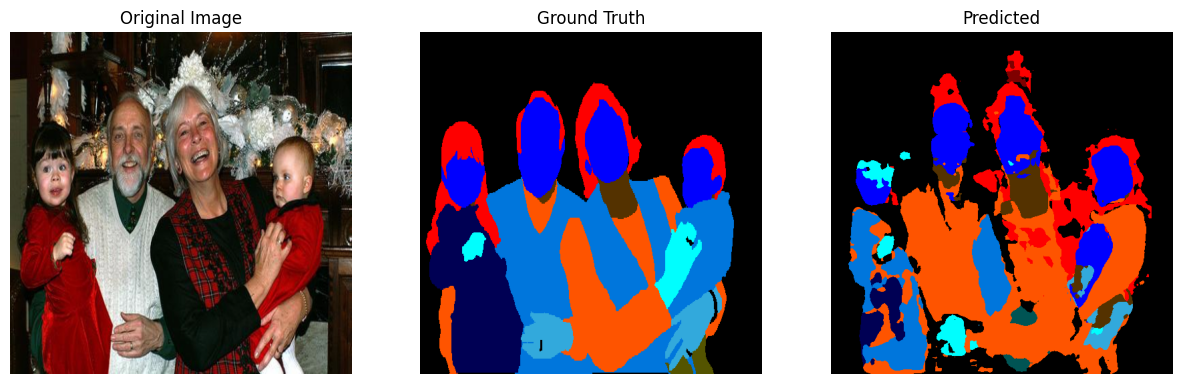

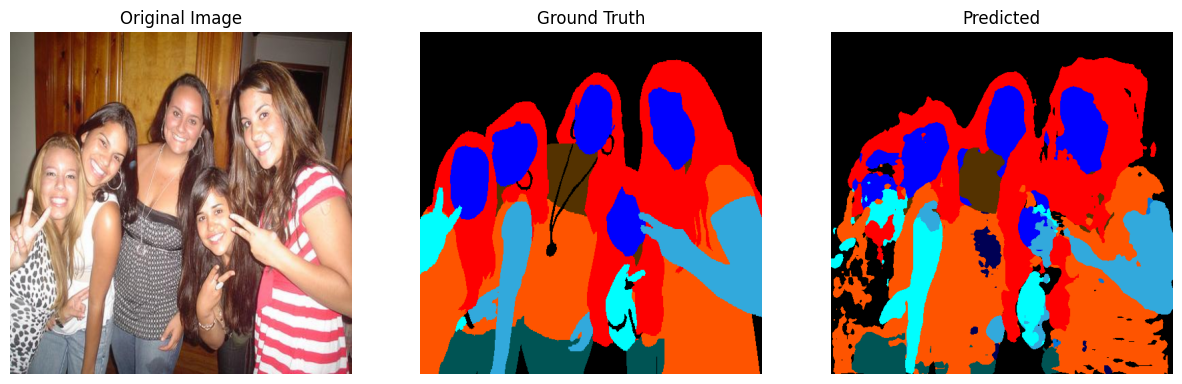

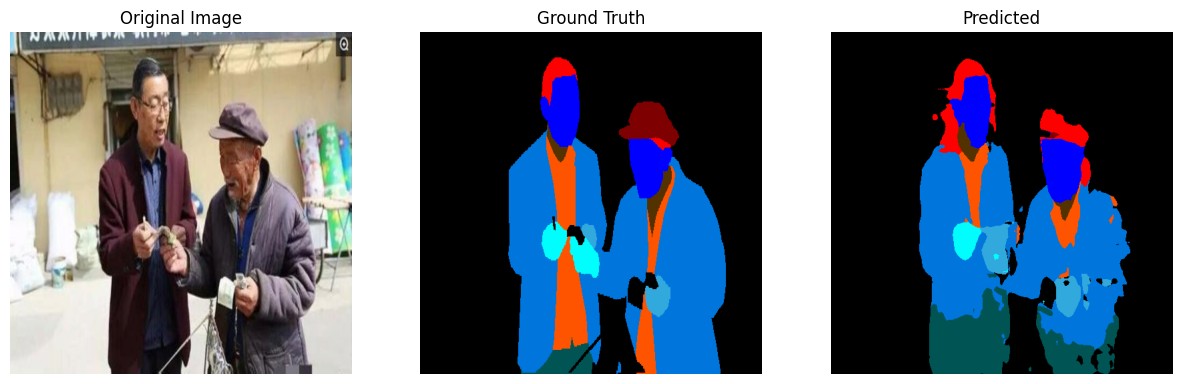

In [45]:
import matplotlib.pyplot as plt

# 시각화
model.eval()
with torch.no_grad():
    for idx in range(3):  # 샘플 3개만 시각화
        image, mask = val_dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu()

        # 원본 이미지 변환
        orig_image = image.permute(1, 2, 0).cpu().numpy()
        orig_image = (orig_image * np.array([0.229, 0.224, 0.225]) +
                     np.array([0.485, 0.456, 0.406]))
        orig_image = np.clip(orig_image, 0, 1)
        orig_image = (orig_image * 255).astype(np.uint8)

        # 마스크 디코딩
        decoded_mask = decode_segmap(pred, colormap)
        true_mask = decode_segmap(mask, colormap)

        # 결과 표시
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(orig_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask)
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(decoded_mask)
        plt.title('Predicted')
        plt.axis('off')

        plt.show()